In [1]:
# MIT License
#
# Copyright (c) 2021 Nikolay Zakharevich ITMO University                                                                                                                 # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# Thove copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Обучение моделей

In [2]:
from app.common.columns import EMOTIONS
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa as lbr
import librosa.display

from IPython.display import Image
from pathlib import Path
from app.common.view import show_emotions_frequencies, display_confusion_matrix, show_history
from app.features.features import extract_audio_features_v1
from app.common.preparation import copy_first_30_seconds, compose, save_extracted_features, load_data_from_dumps
from app.common.columns import EMOTIONS
from app.emotion.crnn import EmotionClassifier

from tensorflow.keras.utils import plot_model

import os
import warnings
warnings.filterwarnings('ignore')


# for tensorflow.keras.utils.plot_model
os.environ['PATH'] += os.pathsep + '/usr/local/bin/dot'

%load_ext autoreload

%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Подготовка данных

Загрузка файла с треками:

In [3]:
DIR_DATA = 'data/'
if not os.path.isdir(DIR_DATA) and os.path.isdir('../dataset/data/'):
    os.rename('../dataset/data/', DIR_DATA)

FILE_TRACKS = DIR_DATA + 'tracks.csv'

tracks_all = pd.read_csv(FILE_TRACKS)
tracks_all.dropna(subset=['audio_path'], inplace=True) 
print(f'Количество треков всего: {len(tracks_all)}')

Количество треков всего: 8022


### Feature extraction

Использовать непосредственно звуковые сигналы во временной области долго и не очень эффективно. Спектрограмма — уже быстрее, но не намного эффективнее, одно из рациональных решений — мел-спектрограмма. Ее вычисляют по обычной спектрограмме, построенной с помощью оконного преобразования Фурье. 

Вот так она выглядит:

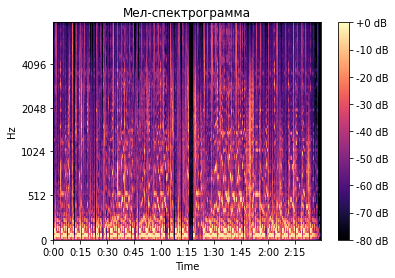

Точки:  [[-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 ...
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]]
Размерность:  (128, 6452)


In [4]:
DIR_AUDIOS = DIR_DATA + 'audios/'

audio_path = DIR_AUDIOS + os.listdir(DIR_AUDIOS)[0]

new_input, sample_rate = lbr.load(audio_path, mono=True)
mel_spect = lbr.feature.melspectrogram(new_input, sr=sample_rate, n_fft=2048, hop_length=1024)
mel_spect = lbr.power_to_db(mel_spect, ref=np.max)
lbr.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Мел-спектрограмма');
plt.colorbar(format='%+2.0f dB');
plt.show()
print('Точки: ', mel_spect)
print('Размерность: ', mel_spect.shape)

Для начала можно попробовать взять от каждого трека только первые 30 секунд: будет проще выровнять размерности для признаков, будет меньше проблем с нехваткой памяти

In [5]:
Path(DIR_DATA + 'audios_30s').mkdir(parents=True, exist_ok=True)

def get_short_audio_path(audio_path: str):
    return audio_path.replace('audios', 'audios_30s')

n_tracks = len(tracks_all)
for idx, audio_path in enumerate(tracks_all.audio_path):
    print(f'Extracting first 30 seconds from track: {audio_path} ({idx + 1} / {n_tracks})...')
    short_audio_path = get_short_audio_path(audio_path)
    if os.path.isfile(audio_path) and not os.path.isfile(short_audio_path):
        copy_first_30_seconds(audio_path, short_audio_path) 

Extracting first 30 seconds from track: data/audios/84165.mp3 (1 / 8022)...
Extracting first 30 seconds from track: data/audios/378874.mp3 (2 / 8022)...
Extracting first 30 seconds from track: data/audios/3644979.mp3 (3 / 8022)...
Extracting first 30 seconds from track: data/audios/975.mp3 (4 / 8022)...
Extracting first 30 seconds from track: data/audios/37390.mp3 (5 / 8022)...
Extracting first 30 seconds from track: data/audios/645159.mp3 (6 / 8022)...
Extracting first 30 seconds from track: data/audios/10637488.mp3 (7 / 8022)...
Extracting first 30 seconds from track: data/audios/632004.mp3 (8 / 8022)...
Extracting first 30 seconds from track: data/audios/26278.mp3 (9 / 8022)...
Extracting first 30 seconds from track: data/audios/153095.mp3 (10 / 8022)...
Extracting first 30 seconds from track: data/audios/629663.mp3 (11 / 8022)...
Extracting first 30 seconds from track: data/audios/628397.mp3 (12 / 8022)...
Extracting first 30 seconds from track: data/audios/83662.mp3 (13 / 8022)...

Extracting first 30 seconds from track: data/audios/32534132.mp3 (1053 / 8022)...
Extracting first 30 seconds from track: data/audios/16408714.mp3 (1054 / 8022)...
Extracting first 30 seconds from track: data/audios/36550013.mp3 (1055 / 8022)...
Extracting first 30 seconds from track: data/audios/37818215.mp3 (1056 / 8022)...
Extracting first 30 seconds from track: data/audios/37787105.mp3 (1057 / 8022)...
Extracting first 30 seconds from track: data/audios/38276358.mp3 (1058 / 8022)...
Extracting first 30 seconds from track: data/audios/38459181.mp3 (1059 / 8022)...
Extracting first 30 seconds from track: data/audios/63030922.mp3 (1060 / 8022)...
Extracting first 30 seconds from track: data/audios/37032174.mp3 (1061 / 8022)...
Extracting first 30 seconds from track: data/audios/53447097.mp3 (1062 / 8022)...
Extracting first 30 seconds from track: data/audios/29332493.mp3 (1063 / 8022)...
Extracting first 30 seconds from track: data/audios/2782600.mp3 (1064 / 8022)...
Extracting first 

Extracting first 30 seconds from track: data/audios/4785989.mp3 (1366 / 8022)...
Extracting first 30 seconds from track: data/audios/328036.mp3 (1367 / 8022)...
Extracting first 30 seconds from track: data/audios/46628536.mp3 (1368 / 8022)...
Extracting first 30 seconds from track: data/audios/672470.mp3 (1369 / 8022)...
Extracting first 30 seconds from track: data/audios/4373885.mp3 (1370 / 8022)...
Extracting first 30 seconds from track: data/audios/16533389.mp3 (1371 / 8022)...
Extracting first 30 seconds from track: data/audios/2690888.mp3 (1372 / 8022)...
Extracting first 30 seconds from track: data/audios/45146626.mp3 (1373 / 8022)...
Extracting first 30 seconds from track: data/audios/123740.mp3 (1374 / 8022)...
Extracting first 30 seconds from track: data/audios/6145639.mp3 (1375 / 8022)...
Extracting first 30 seconds from track: data/audios/46716735.mp3 (1376 / 8022)...
Extracting first 30 seconds from track: data/audios/98846.mp3 (1377 / 8022)...
Extracting first 30 seconds f

Extracting first 30 seconds from track: data/audios/155062.mp3 (1799 / 8022)...
Extracting first 30 seconds from track: data/audios/655148.mp3 (1800 / 8022)...
Extracting first 30 seconds from track: data/audios/61951440.mp3 (1801 / 8022)...
Extracting first 30 seconds from track: data/audios/64357954.mp3 (1802 / 8022)...
Extracting first 30 seconds from track: data/audios/64357962.mp3 (1803 / 8022)...
Extracting first 30 seconds from track: data/audios/64358696.mp3 (1804 / 8022)...
Extracting first 30 seconds from track: data/audios/64356912.mp3 (1805 / 8022)...
Extracting first 30 seconds from track: data/audios/64293957.mp3 (1806 / 8022)...
Extracting first 30 seconds from track: data/audios/64295221.mp3 (1807 / 8022)...
Extracting first 30 seconds from track: data/audios/64295222.mp3 (1808 / 8022)...
Extracting first 30 seconds from track: data/audios/64329424.mp3 (1809 / 8022)...
Extracting first 30 seconds from track: data/audios/64358639.mp3 (1810 / 8022)...
Extracting first 30 

Extracting first 30 seconds from track: data/audios/148504.mp3 (2350 / 8022)...
Extracting first 30 seconds from track: data/audios/148509.mp3 (2351 / 8022)...
Extracting first 30 seconds from track: data/audios/148507.mp3 (2352 / 8022)...
Extracting first 30 seconds from track: data/audios/148512.mp3 (2353 / 8022)...
Extracting first 30 seconds from track: data/audios/148506.mp3 (2354 / 8022)...
Extracting first 30 seconds from track: data/audios/148510.mp3 (2355 / 8022)...
Extracting first 30 seconds from track: data/audios/148511.mp3 (2356 / 8022)...
Extracting first 30 seconds from track: data/audios/226286.mp3 (2357 / 8022)...
Extracting first 30 seconds from track: data/audios/226289.mp3 (2358 / 8022)...
Extracting first 30 seconds from track: data/audios/226281.mp3 (2359 / 8022)...
Extracting first 30 seconds from track: data/audios/226283.mp3 (2360 / 8022)...
Extracting first 30 seconds from track: data/audios/226285.mp3 (2361 / 8022)...
Extracting first 30 seconds from track: 

Extracting first 30 seconds from track: data/audios/38758082.mp3 (3005 / 8022)...
Extracting first 30 seconds from track: data/audios/3616433.mp3 (3006 / 8022)...
Extracting first 30 seconds from track: data/audios/5320827.mp3 (3007 / 8022)...
Extracting first 30 seconds from track: data/audios/437197.mp3 (3008 / 8022)...
Extracting first 30 seconds from track: data/audios/2690823.mp3 (3009 / 8022)...
Extracting first 30 seconds from track: data/audios/629253.mp3 (3010 / 8022)...
Extracting first 30 seconds from track: data/audios/631295.mp3 (3011 / 8022)...
Extracting first 30 seconds from track: data/audios/606309.mp3 (3012 / 8022)...
Extracting first 30 seconds from track: data/audios/629359.mp3 (3013 / 8022)...
Extracting first 30 seconds from track: data/audios/43717991.mp3 (3014 / 8022)...
Extracting first 30 seconds from track: data/audios/24270438.mp3 (3015 / 8022)...
Extracting first 30 seconds from track: data/audios/25451820.mp3 (3016 / 8022)...
Extracting first 30 seconds f

Extracting first 30 seconds from track: data/audios/27902973.mp3 (3404 / 8022)...
Extracting first 30 seconds from track: data/audios/19108175.mp3 (3405 / 8022)...
Extracting first 30 seconds from track: data/audios/41759737.mp3 (3406 / 8022)...
Extracting first 30 seconds from track: data/audios/36476833.mp3 (3407 / 8022)...
Extracting first 30 seconds from track: data/audios/5899164.mp3 (3408 / 8022)...
Extracting first 30 seconds from track: data/audios/38831635.mp3 (3409 / 8022)...
Extracting first 30 seconds from track: data/audios/5508190.mp3 (3410 / 8022)...
Extracting first 30 seconds from track: data/audios/38366358.mp3 (3411 / 8022)...
Extracting first 30 seconds from track: data/audios/33002801.mp3 (3412 / 8022)...
Extracting first 30 seconds from track: data/audios/14553164.mp3 (3413 / 8022)...
Extracting first 30 seconds from track: data/audios/33894103.mp3 (3414 / 8022)...
Extracting first 30 seconds from track: data/audios/23316816.mp3 (3415 / 8022)...
Extracting first 3

Extracting first 30 seconds from track: data/audios/61536214.mp3 (4161 / 8022)...
Extracting first 30 seconds from track: data/audios/58514741.mp3 (4162 / 8022)...
Extracting first 30 seconds from track: data/audios/23979848.mp3 (4163 / 8022)...
Extracting first 30 seconds from track: data/audios/36718702.mp3 (4164 / 8022)...
Extracting first 30 seconds from track: data/audios/46155867.mp3 (4165 / 8022)...
Extracting first 30 seconds from track: data/audios/61331166.mp3 (4166 / 8022)...
Extracting first 30 seconds from track: data/audios/59889925.mp3 (4167 / 8022)...
Extracting first 30 seconds from track: data/audios/32193852.mp3 (4168 / 8022)...
Extracting first 30 seconds from track: data/audios/37281746.mp3 (4169 / 8022)...
Extracting first 30 seconds from track: data/audios/46157068.mp3 (4170 / 8022)...
Extracting first 30 seconds from track: data/audios/65591228.mp3 (4171 / 8022)...
Extracting first 30 seconds from track: data/audios/3958892.mp3 (4172 / 8022)...
Extracting first 

Extracting first 30 seconds from track: data/audios/29213459.mp3 (4466 / 8022)...
Extracting first 30 seconds from track: data/audios/29213458.mp3 (4467 / 8022)...
Extracting first 30 seconds from track: data/audios/48591784.mp3 (4468 / 8022)...
Extracting first 30 seconds from track: data/audios/9896282.mp3 (4469 / 8022)...
Extracting first 30 seconds from track: data/audios/36550740.mp3 (4470 / 8022)...
Extracting first 30 seconds from track: data/audios/36740213.mp3 (4471 / 8022)...
Extracting first 30 seconds from track: data/audios/36740210.mp3 (4472 / 8022)...
Extracting first 30 seconds from track: data/audios/25367667.mp3 (4473 / 8022)...
Extracting first 30 seconds from track: data/audios/9896285.mp3 (4474 / 8022)...
Extracting first 30 seconds from track: data/audios/36740223.mp3 (4475 / 8022)...
Extracting first 30 seconds from track: data/audios/36740219.mp3 (4476 / 8022)...
Extracting first 30 seconds from track: data/audios/9896281.mp3 (4477 / 8022)...
Extracting first 30

Extracting first 30 seconds from track: data/audios/1018898.mp3 (5410 / 8022)...
Extracting first 30 seconds from track: data/audios/19360563.mp3 (5411 / 8022)...
Extracting first 30 seconds from track: data/audios/19360545.mp3 (5412 / 8022)...
Extracting first 30 seconds from track: data/audios/36318154.mp3 (5413 / 8022)...
Extracting first 30 seconds from track: data/audios/17056849.mp3 (5414 / 8022)...
Extracting first 30 seconds from track: data/audios/2766210.mp3 (5415 / 8022)...
Extracting first 30 seconds from track: data/audios/33916020.mp3 (5416 / 8022)...
Extracting first 30 seconds from track: data/audios/33916021.mp3 (5417 / 8022)...
Extracting first 30 seconds from track: data/audios/5533086.mp3 (5418 / 8022)...
Extracting first 30 seconds from track: data/audios/33916022.mp3 (5419 / 8022)...
Extracting first 30 seconds from track: data/audios/133083.mp3 (5420 / 8022)...
Extracting first 30 seconds from track: data/audios/216210.mp3 (5421 / 8022)...
Extracting first 30 sec

Extracting first 30 seconds from track: data/audios/50880661.mp3 (5693 / 8022)...
Extracting first 30 seconds from track: data/audios/62431979.mp3 (5694 / 8022)...
Extracting first 30 seconds from track: data/audios/64267007.mp3 (5695 / 8022)...
Extracting first 30 seconds from track: data/audios/43321428.mp3 (5696 / 8022)...
Extracting first 30 seconds from track: data/audios/58880505.mp3 (5697 / 8022)...
Extracting first 30 seconds from track: data/audios/70777763.mp3 (5698 / 8022)...
Extracting first 30 seconds from track: data/audios/41284287.mp3 (5699 / 8022)...
Extracting first 30 seconds from track: data/audios/31467809.mp3 (5700 / 8022)...
Extracting first 30 seconds from track: data/audios/61145291.mp3 (5701 / 8022)...
Extracting first 30 seconds from track: data/audios/53506685.mp3 (5702 / 8022)...
Extracting first 30 seconds from track: data/audios/39530666.mp3 (5703 / 8022)...
Extracting first 30 seconds from track: data/audios/40649497.mp3 (5704 / 8022)...
Extracting first

Extracting first 30 seconds from track: data/audios/330822.mp3 (6259 / 8022)...
Extracting first 30 seconds from track: data/audios/330805.mp3 (6260 / 8022)...
Extracting first 30 seconds from track: data/audios/143187.mp3 (6261 / 8022)...
Extracting first 30 seconds from track: data/audios/257152.mp3 (6262 / 8022)...
Extracting first 30 seconds from track: data/audios/330811.mp3 (6263 / 8022)...
Extracting first 30 seconds from track: data/audios/29478366.mp3 (6264 / 8022)...
Extracting first 30 seconds from track: data/audios/22826450.mp3 (6265 / 8022)...
Extracting first 30 seconds from track: data/audios/29478367.mp3 (6266 / 8022)...
Extracting first 30 seconds from track: data/audios/29478368.mp3 (6267 / 8022)...
Extracting first 30 seconds from track: data/audios/29478369.mp3 (6268 / 8022)...
Extracting first 30 seconds from track: data/audios/29478370.mp3 (6269 / 8022)...
Extracting first 30 seconds from track: data/audios/29478371.mp3 (6270 / 8022)...
Extracting first 30 second

Extracting first 30 seconds from track: data/audios/661501.mp3 (6575 / 8022)...
Extracting first 30 seconds from track: data/audios/665481.mp3 (6576 / 8022)...
Extracting first 30 seconds from track: data/audios/21280652.mp3 (6577 / 8022)...
Extracting first 30 seconds from track: data/audios/21280654.mp3 (6578 / 8022)...
Extracting first 30 seconds from track: data/audios/21280659.mp3 (6579 / 8022)...
Extracting first 30 seconds from track: data/audios/629352.mp3 (6580 / 8022)...
Extracting first 30 seconds from track: data/audios/13490152.mp3 (6581 / 8022)...
Extracting first 30 seconds from track: data/audios/15298875.mp3 (6582 / 8022)...
Extracting first 30 seconds from track: data/audios/1049591.mp3 (6583 / 8022)...
Extracting first 30 seconds from track: data/audios/57745077.mp3 (6584 / 8022)...
Extracting first 30 seconds from track: data/audios/57745078.mp3 (6585 / 8022)...
Extracting first 30 seconds from track: data/audios/57745083.mp3 (6586 / 8022)...
Extracting first 30 sec

Extracting first 30 seconds from track: data/audios/659488.mp3 (7564 / 8022)...
Extracting first 30 seconds from track: data/audios/4434459.mp3 (7565 / 8022)...
Extracting first 30 seconds from track: data/audios/20947458.mp3 (7566 / 8022)...
Extracting first 30 seconds from track: data/audios/349415.mp3 (7567 / 8022)...
Extracting first 30 seconds from track: data/audios/28140001.mp3 (7568 / 8022)...
Extracting first 30 seconds from track: data/audios/18159904.mp3 (7569 / 8022)...
Extracting first 30 seconds from track: data/audios/436992.mp3 (7570 / 8022)...
Extracting first 30 seconds from track: data/audios/2774867.mp3 (7571 / 8022)...
Extracting first 30 seconds from track: data/audios/269845.mp3 (7572 / 8022)...
Extracting first 30 seconds from track: data/audios/33644231.mp3 (7573 / 8022)...
Extracting first 30 seconds from track: data/audios/49205714.mp3 (7574 / 8022)...
Extracting first 30 seconds from track: data/audios/39957536.mp3 (7575 / 8022)...
Extracting first 30 second

Extracting first 30 seconds from track: data/audios/29670557.mp3 (7809 / 8022)...
Extracting first 30 seconds from track: data/audios/22434771.mp3 (7810 / 8022)...
Extracting first 30 seconds from track: data/audios/32498413.mp3 (7811 / 8022)...
Extracting first 30 seconds from track: data/audios/25481740.mp3 (7812 / 8022)...
Extracting first 30 seconds from track: data/audios/19217772.mp3 (7813 / 8022)...
Extracting first 30 seconds from track: data/audios/28056553.mp3 (7814 / 8022)...
Extracting first 30 seconds from track: data/audios/13903030.mp3 (7815 / 8022)...
Extracting first 30 seconds from track: data/audios/15362088.mp3 (7816 / 8022)...
Extracting first 30 seconds from track: data/audios/18049191.mp3 (7817 / 8022)...
Extracting first 30 seconds from track: data/audios/23555951.mp3 (7818 / 8022)...
Extracting first 30 seconds from track: data/audios/24466082.mp3 (7819 / 8022)...
Extracting first 30 seconds from track: data/audios/24464670.mp3 (7820 / 8022)...
Extracting first

Каждый раз ждать пока извлекаются признаки не хочется, можно извлечь из всех один раз и сохранить. Большой файл загружать тяжело и страшно, поэтому треки разбиваются на десять частей:

In [6]:
DIR_DUMPS = DIR_DATA + 'dumps/'

if False:
    save_extracted_features(
        tracks=tracks,
        dump_dir=DIR_DUMPS,
        use_short_audio=True,
        n_batches=10
    )

## Multiclass-classification: одна эмоция на трек



Количество треков с хотя бы одной эмоцией: 5532
Количество треков с ровно одной эмоцией: 5269


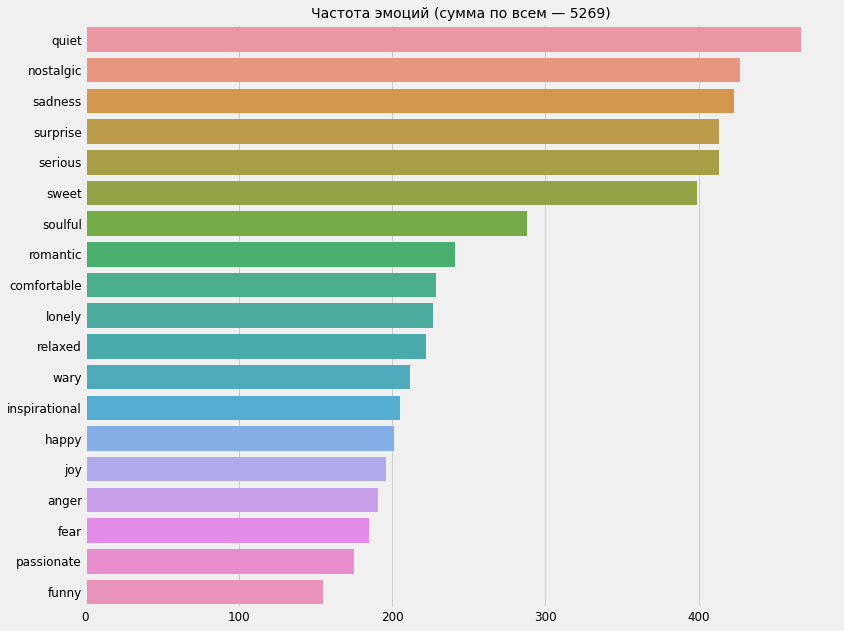

In [7]:
tracks = tracks_all.dropna(subset=['emotions'])
print(f'Количество треков с хотя бы одной эмоцией: {len(tracks)}')


# Оставляем треки с одной эмоцией
tracks = tracks[tracks.apply(lambda t: '|' not in t.emotions, axis=1)]
print(f'Количество треков с ровно одной эмоцией: {len(tracks)}')
show_emotions_frequencies(tracks)


Обрезка популярных эмоций:

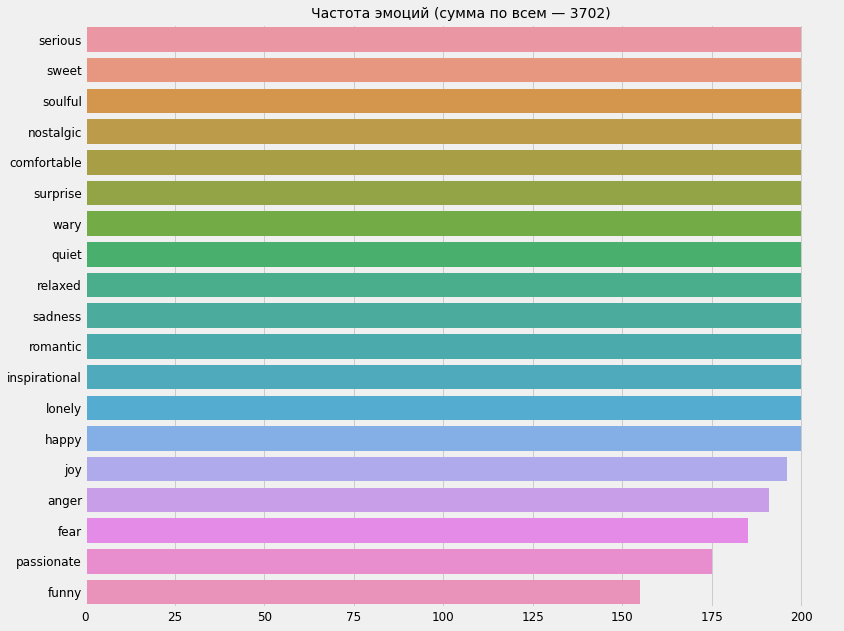

In [8]:
tracks = tracks.groupby(['emotions']).head(200)
show_emotions_frequencies(tracks)

Загрузка данных для обучения:

In [9]:
DIR_DUMPS = DIR_DATA + 'dumps/'
print('Загрузка уже извлечённых признаков...')
tracks_data = load_data_from_dumps(tracks, DIR_DUMPS)

tracks_data_len = len(tracks_data)
print(f'Загружено {tracks_data_len} треков')


X_all, y_all = map(list, zip(*tracks_data.values()))
if len(tracks_data) < len(tracks):
    lb = LabelBinarizer()
    lb.fit(EMOTIONS)
    print('Извлечение из оставшихся треков...')
    tracks_rest = tracks[~track.ym_track_id.isin(tracks_data.keys())]
    for track in tracks_rest.iterrows():
        short_audio_path = get_short_audio_path(track.audio_path)
        X_all.append(extract_audio_features_v1(short_audio_path))
        y_all.append(lb.transform(track.features))

X, y = np.array(X_all), np.array(y_all)
print(f'X shape: {X.shape}')
print(f'Y shape: {y.shape}')

Загрузка уже извлечённых признаков...
Загружено 3702 треков
X shape: (3702, 646, 128)
Y shape: (3702, 19)


Обучение модели:

Building model...


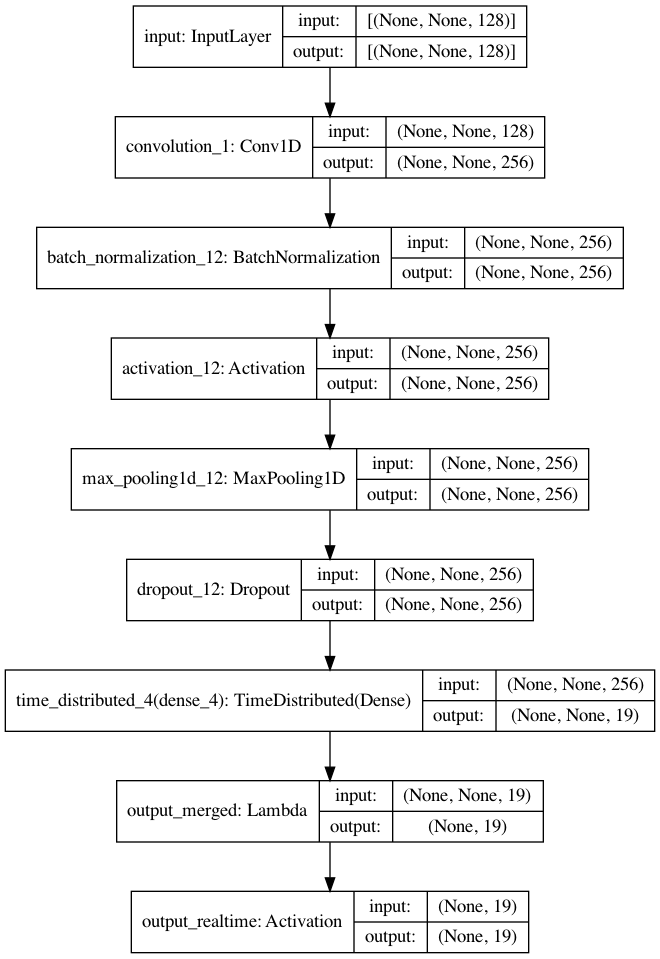

In [19]:
DIR_IMAGES = 'images/'
model_name = 'emotions_crnn_v1'

emotion_model_v1 = EmotionClassifier.build_model(n_features=X.shape[2])

model_image = f'{DIR_IMAGES}{model_name}.png'
plot_model(emotion_model_v1, show_shapes=True, to_file=model_image)
Image(filename=model_image)

Обучение модели:

In [ ]:
DIR_MODELS = 'models/'
model_path = f'{DIR_MODELS}{model_name}.h5'

emotion_model_v1, history = EmotionClassifier.train_model(
    emotion_model_v1, 
    X, 
    y, 
    model_path, 
    epochs=50,
    test_size=0.1
)
show_history(history, 'CRRN emotion classifier')

Training...
Epoch 1/50
37/53 [===================>..........] - ETA: 5s - loss: 2.8779 - accuracy: 0.1091 - top3-accuracy: 0.2670

## Multilabel-classification: несколько эмоций на трек